### Theory About Reproducibility

During the training of the model the Python version and the library version freezing was not taken care of, or rather was not required because in various different environments this notebook ran as it is, still the last environment configurations were as follows:
- Python 3.13
- Tensorflow 2.20
- Numpy 2.0

This environment freezing became a huge concern while quantizing the model and running it on RaspberryPi (more on that in their respective notebooks/READMEs).

### Extras/Good to Knows
#### Port Forwarding on Server
To run a notebook on remote server (or inception of servers as we did on our department's two level deep servers) you can either pull a non interactive Python file and run on screen/tmux session which is not ideal, or, you can run a Jupyter notebook inside the server and forward the port to your local host. For the latter you'd require the following: 
```bash
ssh -L 8888:localhost:8888 user@ip # forwarding remote 8888 port to your local 8888 port while ssh-ing into the machine

# Now inside the remote server
cd doodle-vision
source .tens/bin/active
jupyter notebook --no-browser --port=8888 # run the notebook on port 8888
# Now just copy paste the link into your local browser.
```
This works when more than one servers are running inside each other, for example, we must log into the department server and from that we login to the desired server. In such case we carry forward the port forwarding the same way

#### Using Virtual Environment as Kernel
In order to get more control on the kernel we can use the virtual environment as kernel. This helps control not only the libraries' version but the Python version also. To do so: 
```bash
cd doodle-vision
python3.12 -m venv .tens # Use python 3.12. The name .tens signifies it will have tensorflow without CUDA.
source .tens/bin/activate

pip install jupyter ipykernel # Install the packages to help Jupyter identify it.
python -m ipykernel install --user --name=.tens # Register/install this virtual environment as kernel.
```

### Prerequisites (uncomment to run)

#### Installations

In [1]:
# Assuming the virtual environment .tens-and-cuda is being used
%pip install tensorflow[and-cuda] numpy tqdm matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/priyanka/doodle-vision/.tens-and-cuda/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Data preprocessing

In [2]:
# # Step 1: Download QuickDraw dataset
# %python download_data.py

# # Step 2: Combine stroke data across different partitions (train, val, test).
# # The original data (e.g., airplanes.npz) is split into these partitions, 
# # which reduces the number of data points. We merge all partitions for a complete dataset.
# %python combine_strokes.py

# # Step 3: Convert each `.npy` and `.npz` file into individual sample files.
# # For example, `airplanes.npy` contains (N, 784), where N is the number of samples 
# # and each sample is a flattened 28x28 image (784 features). We split this into
# # individual `.npy` files like `airplanes/000001.npy`, `airplanes/000002.npy`, etc.
# # This allows us to load specific slices of data (e.g., airplanes[3012:33012]) 
# # without having to load the entire file, reducing memory usage and avoiding memory eviction issues.
# %python convert_to_individual_npys.py

### Imports

In [3]:
import datetime
import gc
import json
import math
import os
import pickle
import random
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import (
    BackupAndRestore,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv2D,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
)
from tensorflow.keras.models import Model
from tqdm import tqdm


### GPU Configs

In [4]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1755336908.211149   79987 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22160 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


### Global Variables

In [5]:
# Files
DATA_DIR_IMAGES = "dataset/images"
DATA_DIR_STROKES = "dataset/combined_strokes"
LABELS_JSON    = "dataset/label_map.json"
PROCESSED_DATA_DIR = "dataset/processed"

# Data props
NUM_CLASSES = 345

# Data props (image)
IMG_HEIGHT     = 28
IMG_WIDTH      = 28
IMG_CHANNELS   = 1

# Data props (stroke)
MAX_STROKES_LEN = 130
STROKES_FEATURES = 3

# Training
SAMPLES_PER_CLASS = 30_000
SPLIT_RATIOS = (0.8, 0.1, 0.1) # train, val, test
BATCH_SIZE = 512
EPOCHS = 30

# General Config
USE_INDIVIDUAL = True # Whether using the downloaded npy files or preprocessed individual example npy files

# In-memory loading threshold (for 10_000, used 11% of 128GB memory)
IN_MEMORY_THRESHOLD = 30_000  # Load everything to RAM early-on if SAMPLES_PER_CLASS <= this, otherwise load inside the generator
USE_IN_MEMORY = USE_INDIVIDUAL and (SAMPLES_PER_CLASS <= IN_MEMORY_THRESHOLD)


In [6]:
with open(LABELS_JSON, 'r') as f:
    LABEL_MAP = json.load(f)
    
REV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

### Data Preprocessing Helper Functions

In [7]:
def preprocess_image(flat_img):
    """
    Input shape: (784,)
    Output shape: (28, 28, 1), normalized to [0, 1]
    """
    img = flat_img.reshape(28, 28).astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)  # shape: (28, 28, 1)

def preprocess_strokes(strokes, max_len=MAX_STROKES_LEN):
    """
    Improved stroke preprocessing with consistent normalization
    Centers to (0,0) and scales to [-100, 100] range
    """
    strokes = strokes.astype(np.float32)

    # Convert to absolute coordinates
    strokes[:, 0] = np.cumsum(strokes[:, 0])
    strokes[:, 1] = np.cumsum(strokes[:, 1])

    # Center to (0, 0)
    strokes[:, 0] -= strokes[:, 0].mean()
    strokes[:, 1] -= strokes[:, 1].mean()

    # Scale to [-100, 100] range
    if len(strokes) > 0:
        # Find the maximum absolute coordinate value
        max_coord = max(
            np.abs(strokes[:, 0]).max() if len(strokes) > 0 else 1,
            np.abs(strokes[:, 1]).max() if len(strokes) > 0 else 1,
        )

        # Avoid division by zero
        if max_coord > 0:
            # Scale to [-100, 100] range
            scale_factor = 100.0 / max_coord
            strokes[:, 0] *= scale_factor
            strokes[:, 1] *= scale_factor

    # Truncate or pad as before
    if len(strokes) > max_len:
        return strokes[:max_len]

    pad = np.zeros((max_len - len(strokes), STROKES_FEATURES), dtype=np.float32)

    return np.vstack([strokes, pad])

### Model Building

In [8]:
def build_hybrid_model(num_classes):
    inp_str = Input(shape=(MAX_STROKES_LEN, STROKES_FEATURES), name="stroke_input")
    x = Bidirectional(LSTM(128, return_sequences=True))(inp_str)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dense(128, activation="relu")(x)

    inp_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="image_input")
    y = Conv2D(32, 3, activation="relu", padding="same")(inp_img)
    y = MaxPooling2D()(y)
    y = Conv2D(64, 3, activation="relu", padding="same")(y)
    y = BatchNormalization()(y)
    y = MaxPooling2D()(y)
    y = Conv2D(128, 3, activation="relu", padding="same")(y)
    y = BatchNormalization()(y)
    y = MaxPooling2D()(y)
    y = Conv2D(256, 3, activation="relu", padding="same")(y)
    y = GlobalAveragePooling2D()(y)
    y = Dense(128, activation="relu")(y)

    merged = Concatenate()([x, y])
    merged = Dropout(0.5)(merged)
    merged = Dense(256, activation="relu")(merged)
    merged = Dropout(0.3)(merged)
    out = Dense(num_classes, activation="softmax", dtype="float32")(merged)

    return Model(inputs=[inp_str, inp_img], outputs=out, name="hybrid_model")

model = build_hybrid_model(num_classes=NUM_CLASSES)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"],
)

# model.summary()

### Disk Data Loader for Original Data

In [9]:
# When USE_IN_MEMORY: list of numpy objects
# When USE_INDIVIDUAL: list of file paths
# Otherwise: list of (cls_id, example_id)
images = []
strokes = []

# Always list of integers
labels = []

if USE_INDIVIDUAL:
    for cls, label in tqdm(LABEL_MAP.items(), desc="Building dataset"):
        image_files = sorted(
            glob(os.path.join(PROCESSED_DATA_DIR, "images", cls, "*.npy"))
        )
        stroke_files = sorted(
            glob(os.path.join(PROCESSED_DATA_DIR, "strokes", cls, "*.npy"))
        )

        N = min(len(image_files), len(stroke_files), SAMPLES_PER_CLASS)

        for i in range(N):
            image_path = image_files[i]
            stroke_path = stroke_files[i]

            if USE_IN_MEMORY:
                images.append(np.load(image_path))
                strokes.append(np.load(stroke_path))
            else:
                images.append(image_path)
                strokes.append(stroke_path)
            labels.append(label)

    if USE_IN_MEMORY:
        print(f"[In-Memory Mode] Loaded {len(labels):,} samples.")
    else:
        print(f"[Individual Stream Mode] Loaded {len(labels):,} samples.")

else:
    for cls, label in tqdm(LABEL_MAP.items(), desc="Building dataset"):
        image_path = os.path.join(DATA_DIR_IMAGES, f"{cls}.npy")
        stroke_path = os.path.join(DATA_DIR_STROKES, f"{cls}.npz")

        img_arr = np.load(image_path, allow_pickle=True, encoding="latin1", mmap_mode="r")
        str_arr = np.load(stroke_path, allow_pickle=True, encoding="latin1")["strokes"]

        N = min(img_arr.shape[0], len(str_arr), SAMPLES_PER_CLASS)

        for i in range(N):
            images.append((label, i))
            strokes.append((label, i))
            labels.append(label)

    print(f"[Original Mode] Loaded {len(labels):,} samples.")

Building dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [18:24<00:00,  3.20s/it]

[In-Memory Mode] Loaded 10,350,000 samples.


In [10]:
def plot_images_and_strokes(images, strokes, labels, n=100):
    # Pick n random indices
    idxs = random.sample(range(len(labels)), n)

    plt.figure(figsize=(10, n * 1.5))  # Large enough for many rows
    for i, idx in enumerate(idxs):
        # Load image
        if isinstance(images[idx], str):  # Path
            img = np.load(images[idx])
        elif isinstance(images[idx], tuple):  # (label, i) for Original Mode
            label_id, ex_id = images[idx]
            cls = list(LABEL_MAP.keys())[label_id]
            img = np.load(os.path.join(DATA_DIR_IMAGES, f"{cls}.npy"), 
                          mmap_mode="r")[ex_id]
        else:  # Already in memory
            img = images[idx]

        img = img.reshape(28, 28)

        # Load stroke
        if isinstance(strokes[idx], str):  # Path
            strk = np.load(strokes[idx])
        elif isinstance(strokes[idx], tuple):  # (label, i)
            label_id, ex_id = strokes[idx]
            cls = list(LABEL_MAP.keys())[label_id]
            str_arr = np.load(os.path.join(DATA_DIR_STROKES, f"{cls}.npz"),
                              allow_pickle=True)["strokes"]
            strk = str_arr[ex_id]
        else:  # Already in memory
            strk = strokes[idx]

        # Plot
        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Label: {labels[idx]}")

        plt.subplot(n, 2, 2*i + 2)
        plt.plot(strk[:, 0], -strk[:, 1], marker='o', markersize=1)  # Flip y-axis for natural orientation
        plt.axis("equal")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig(f'{n}_random_samples.png')


# plot_images_and_strokes(images, strokes, labels, n=100)

In [11]:
def data_generator(images, strokes, labels):
    # no preprocess stroke or preprocess image because that is already taken care of while 
    # using convert_to_individual_npys.py
    if USE_IN_MEMORY:
        for image, stroke, label in zip(images, strokes, labels):
            yield (
                image,
                stroke,
                tf.one_hot(label, depth=NUM_CLASSES),
            )
    elif USE_INDIVIDUAL:
        for img_path, str_path, label in zip(images, strokes, labels):
            yield (
                np.load(img_path),
                np.load(str_path),
                tf.one_hot(label, depth=NUM_CLASSES),
            )
    else:
        for (img_id, i), (str_id, j), label in zip(images, strokes, labels):
            img_path = os.path.join(DATA_DIR_IMAGES, REV_LABEL_MAP[img_id], ".npy")
            str_path = os.path.join(DATA_DIR_STROKES, REV_LABEL_MAP[str_id], ".npz")
            
            img = np.load(img_path, allow_pickle=True, encoding="latin1", mmap_mode="r")[i]
            strokes = np.load(str_path, allow_pickle=True, encoding="latin1")["strokes"][j]
            yield (
                preprocess_image(img),
                preprocess_strokes(strokes),
                tf.one_hot(label, depth=NUM_CLASSES),
            )

In [12]:
def format_sample(img, stroke, label):
    return {"stroke_input": stroke, "image_input": img}, label

output_signature = (
    tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(130, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.int32),
)

### Train, Val, and Test Splits

In [13]:
# Shuffle once and split
total = len(labels)
indices = np.arange(total)
np.random.seed(42)
np.random.shuffle(indices)

train_end = int(SPLIT_RATIOS[0] * total)
val_end = train_end + int(SPLIT_RATIOS[1] * total)

train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

# Train
train_images =  [images[i] for i in train_idx]
train_strokes = [strokes[i] for i in train_idx]
train_labels =  [labels[i] for i in train_idx]

# Val
val_images =  [images[i] for i in val_idx]
val_strokes = [strokes[i] for i in val_idx]
val_labels =  [labels[i] for i in val_idx]

# Test
test_images =  [images[i] for i in test_idx]
test_strokes = [strokes[i] for i in test_idx]
test_labels =  [labels[i] for i in test_idx]

In [14]:
def build_dataset(images, strokes, labels, is_shuffle=False):
    def gen():
        return data_generator(images, strokes, labels)

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=output_signature
    )

    if is_shuffle:
        ds = ds.shuffle(BATCH_SIZE * 10)

    ds = ds.repeat()
    ds = ds.map(format_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    return ds.prefetch(tf.data.AUTOTUNE)

In [15]:
train_ds = build_dataset(train_images, train_strokes, train_labels, is_shuffle=True)
val_ds  = build_dataset(val_images, val_strokes, val_labels).take(math.ceil(len(val_labels) / BATCH_SIZE))
test_ds = build_dataset(test_images, test_strokes, test_labels).take(math.ceil(len(test_labels) / BATCH_SIZE))

### Model Training and graph plotting

In [ ]:
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

model_name = f"best_model_{NUM_CLASSES}_classes_{SAMPLES_PER_CLASS}_examples"
callbacks = [
    ModelCheckpoint(f"{model_name}.keras", monitor="val_accuracy", save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    MemoryCleanupCallback(),
    BackupAndRestore(backup_dir="./training_backup"),
    TensorBoard(
        log_dir=f"./logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}",
        histogram_freq=1,  # logs weights histograms every epoch
    ),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=math.ceil(len(train_labels) / BATCH_SIZE),
    callbacks=callbacks,
)

# Model has been trained but output relied on consistent ssh connection which I could not maintain, hence the gap in notebook. 
# Refer to training logs using tensorboard for more details.

Epoch 1/30
16172/16172 ━━━━━━━━━━━━━━━━━━━━ 2277s 140ms/step - accuracy: 0.6483 - loss: 2.2652 - val_accuracy: 0.8248 - val_loss: 1.5947 - learning_rate: 0.0010
Epoch 2/30
16172/16172 ━━━━━━━━━━━━━━━━━━━━ 2295s 142ms/step - accuracy: 0.7613 - loss: 1.8449 - val_accuracy: 0.8477 - val_loss: 1.5000 - learning_rate: 0.0010
Epoch 3/30
16172/16172 ━━━━━━━━━━━━━━━━━━━━ 2299s 142ms/step - accuracy: 0.7884 - loss: 1.7526 - val_accuracy: 0.8596 - val_loss: 1.4537 - learning_rate: 0.0010
Epoch 4/30
16172/16172 ━━━━━━━━━━━━━━━━━━━━ 2304s 142ms/step - accuracy: 0.8035 - loss: 1.7014 - val_accuracy: 0.8658 - val_loss: 1.4284 - learning_rate: 0.0010
Epoch 5/30
16172/16172 ━━━━━━━━━━━━━━━━━━━━ 2307s 143ms/step - accuracy: 0.8136 - loss: 1.6676 - val_accuracy: 0.8686 - val_loss: 1.4153 - learning_rate: 0.0010
Epoch 6/30
16172/16172 ━━━━━━━━━━━━━━━━━━━━ 2494s 154ms/step - accuracy: 0.8207 - loss: 1.6435 - val_accuracy: 0.8703 - val_loss: 1.4071 - learning_rate: 0.0010
Epoch 7/30
16172/16172 ━━━━━━━━━━━

In [21]:
with open(f"{model_name}_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

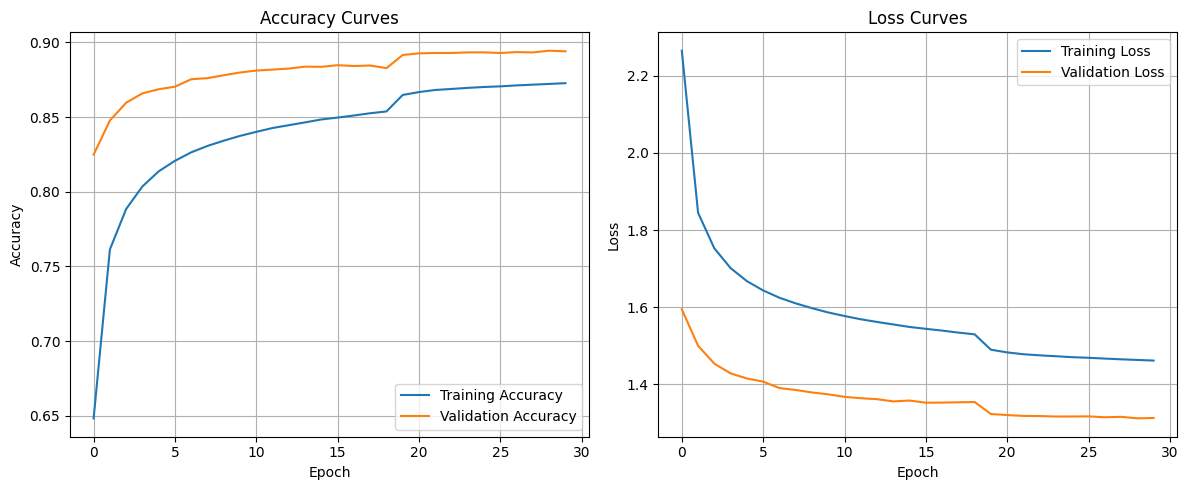

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Model Evaluation on Test Data

In [25]:
eval_model = tf.keras.models.load_model(f"{model_name}.keras")
loss, acc = eval_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")

2022/2022 ━━━━━━━━━━━━━━━━━━━━ 209s 103ms/step - accuracy: 0.8941 - loss: 1.3115
Test Loss: 1.3115 | Test Accuracy: 0.8941


### Model Evaluation on Complete (30K samples) Data

In [ ]:
ds = build_dataset(images, strokes, labels).take(math.ceil(len(labels) / BATCH_SIZE))

eval_model = tf.keras.models.load_model(f"{model_name}.keras")
loss, acc = eval_model.evaluate(ds)
print(f"Test Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")

19756/20215 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - accuracy: 0.9004 - loss: 1.2928  

In [36]:
print(f"Test Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")

Test Loss: 1.2799 | Test Accuracy: 0.9045
